In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/seattle-weather.csv')

In [3]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
#coulmn Open converted into numpy array
training_set = df.iloc[:,2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [7]:
len(training_set)

1461

In [8]:
def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i,0])
    y_train.append(training_set[i,0])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

In [9]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


In [10]:
#Reshaping(To add new dimensions)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [11]:
#Building the RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [12]:
regressor = Sequential()

In [13]:
#Addinf the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

#Output layer
regressor.add(Dense(units=1))

In [14]:
#Compiling
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [16]:
#fitting the rnn to the training set
history=regressor.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 9s 88ms/step - loss: 201.7398 - val_loss: 246.9091
Epoch 2/100
25/25 [==============================] - 1s 20ms/step - loss: 92.0738 - val_loss: 160.5145
Epoch 3/100
25/25 [==============================] - 1s 20ms/step - loss: 70.6306 - val_loss: 131.7901
Epoch 4/100
25/25 [==============================] - 1s 21ms/step - loss: 63.2102 - val_loss: 114.7094
Epoch 5/100
25/25 [==============================] - 1s 21ms/step - loss: 58.0688 - val_loss: 101.9375
Epoch 6/100
25/25 [==============================] - 1s 20ms/step - loss: 55.1862 - val_loss: 92.4950
Epoch 7/100
25/25 [==============================] - 0s 20ms/step - loss: 54.0004 - val_loss: 86.6002
Epoch 8/100
25/25 [==============================] - 0s 19ms/step - loss: 53.7363 - val_loss: 82.2505
Epoch 9/100
25/25 [==============================] - 0s 19ms/step - loss: 53.7470 - val_loss: 79.8001
Epoch 10/100
25/25 [==============================] - 0s 20ms/step - loss: 5

In [17]:
his = pd.DataFrame(history.history)

In [18]:
his.head()

,loss,val_loss
0,201.739822,246.909134
1,92.073776,160.514496
2,70.630608,131.790054
3,63.210239,114.709427
4,58.068817,101.937454


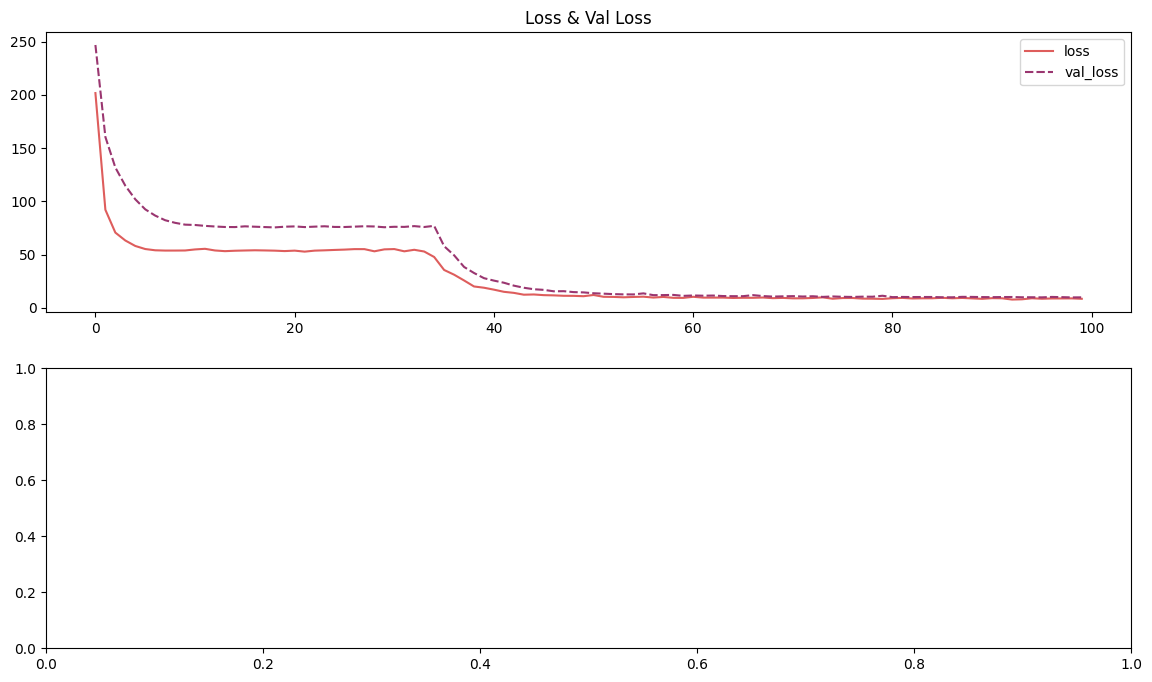

In [19]:
import seaborn as sns
his.columns
history_loss = his[['loss', 'val_loss']]


fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");



In [20]:
train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

15/15 [==============================] - 0s 6ms/step


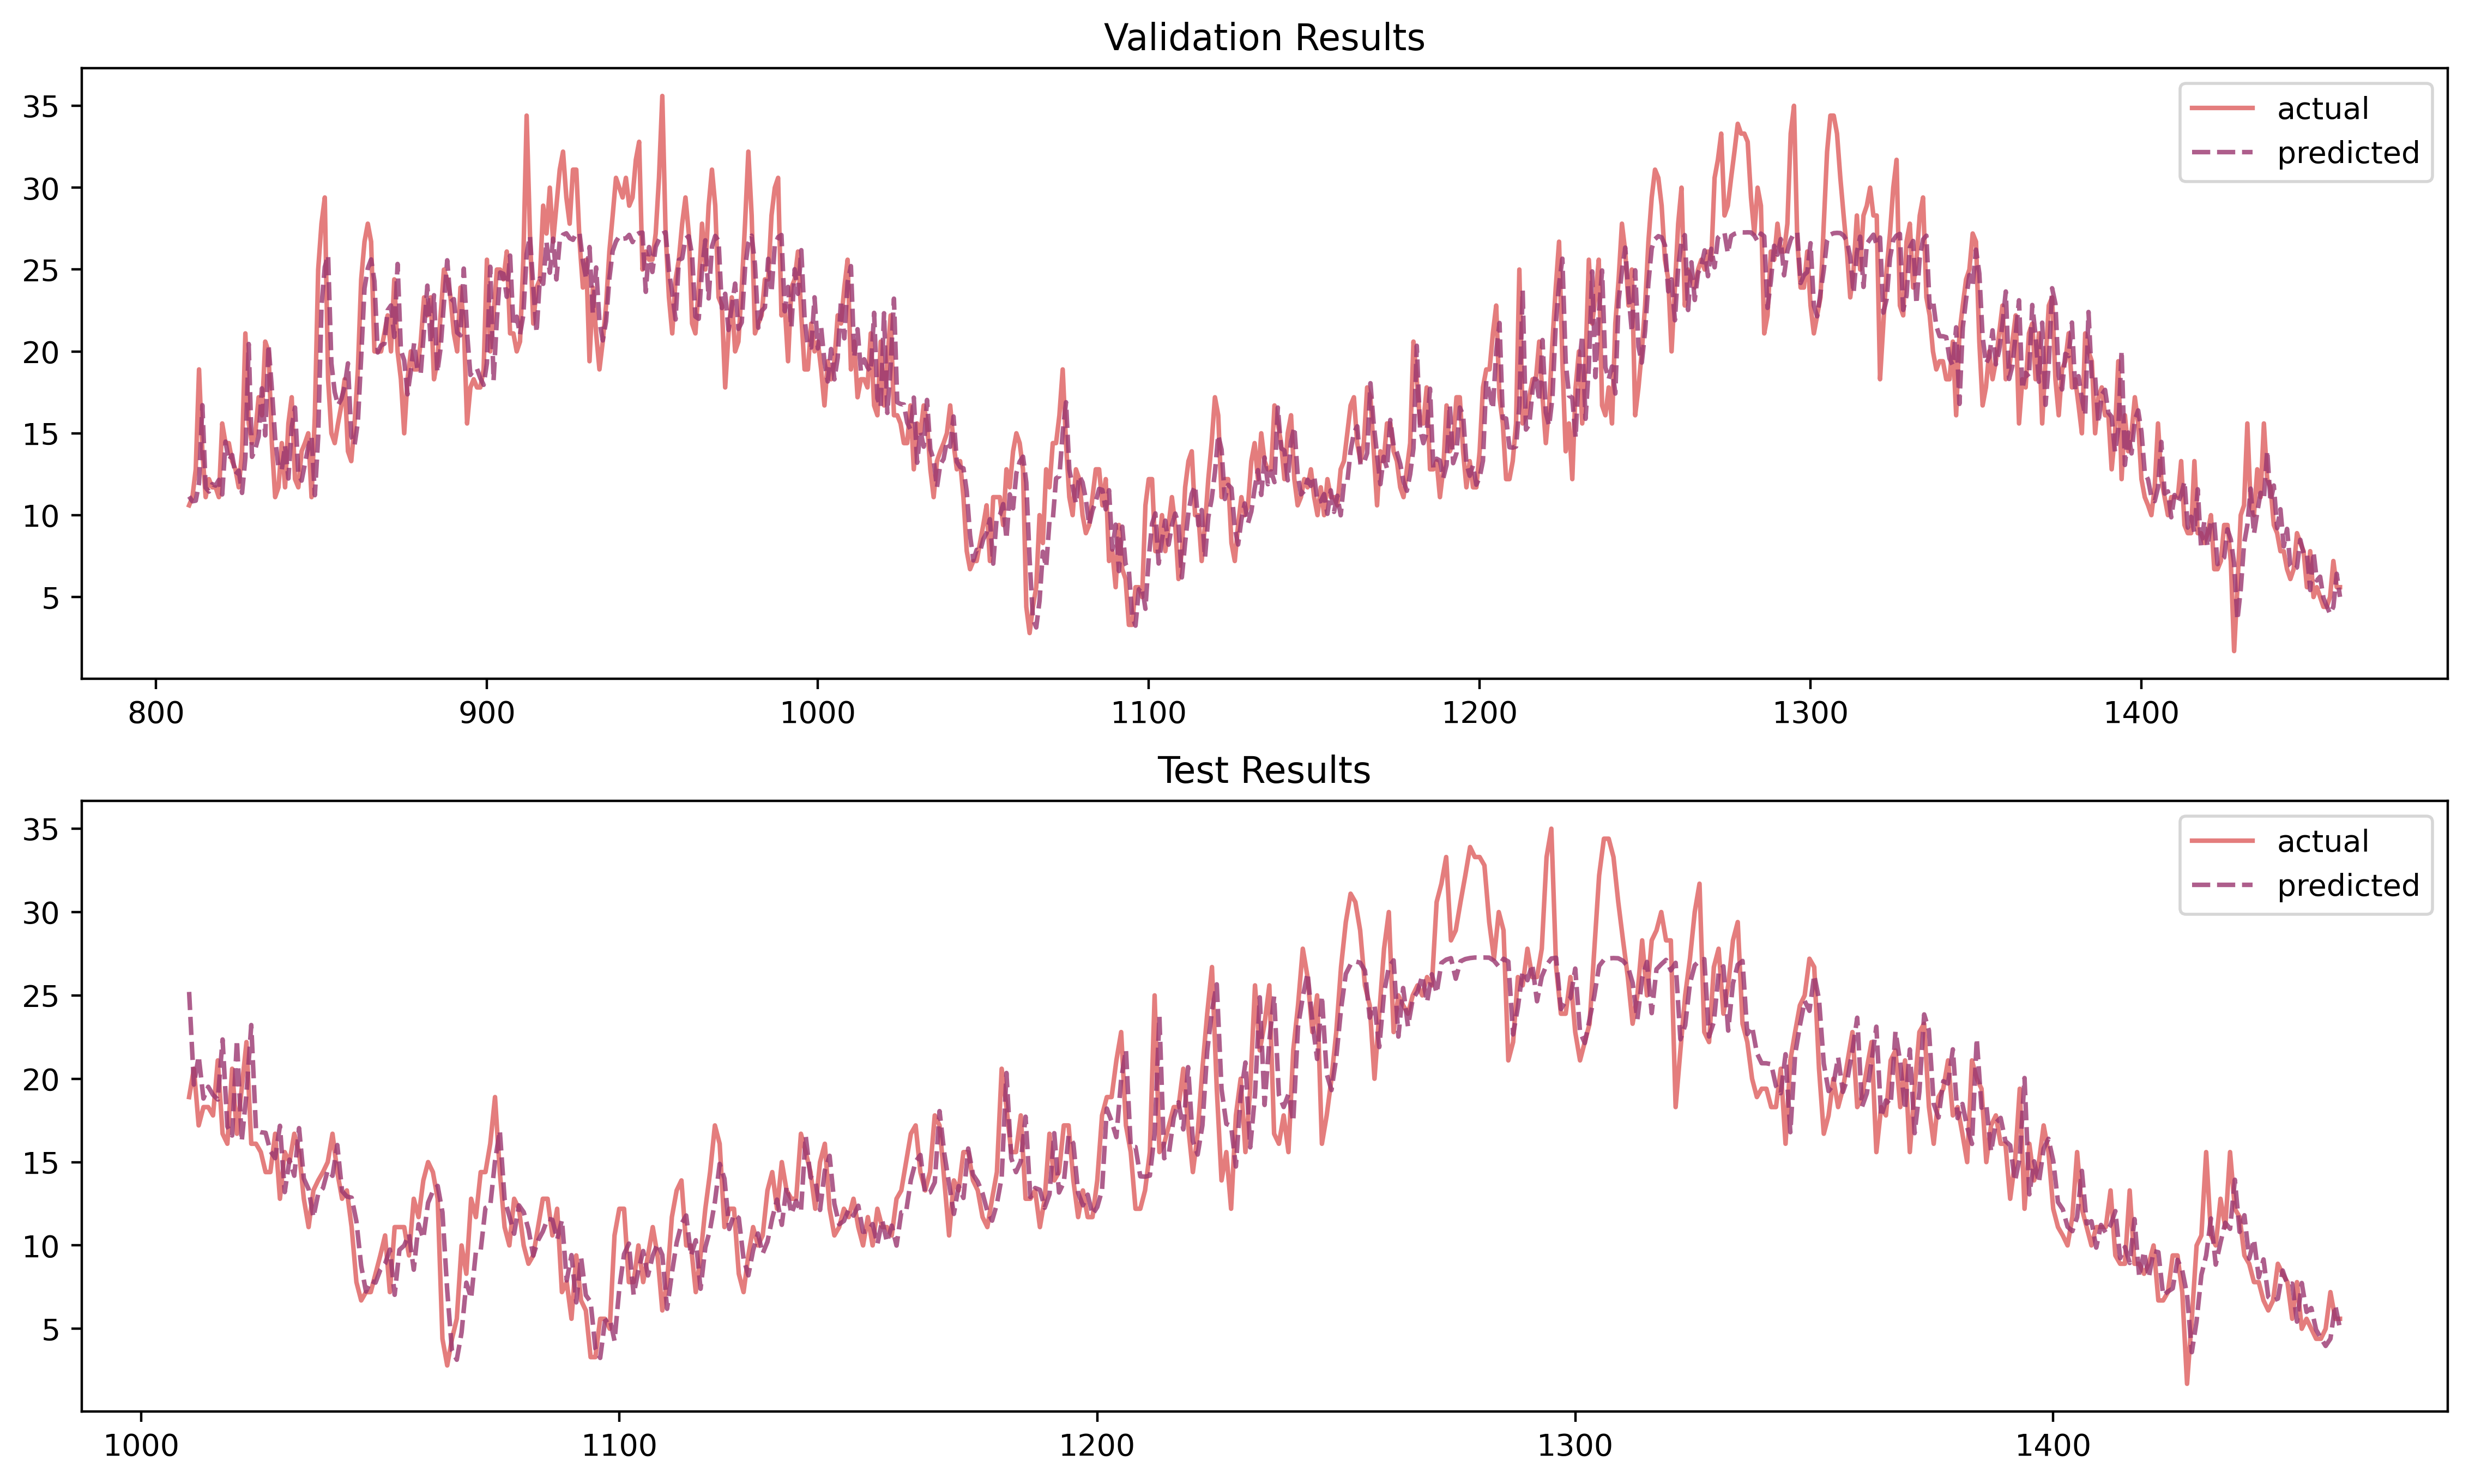

In [21]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);